# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
import gc
import time
import random
import re
from tqdm import tqdm 
import os
import json

def read_json(filepath: str) -> dict:
    with open(filepath, "r") as f:
        return json.load(f)
    
def read_jsonl(filepath: str) -> dict:
    data = []
    with open(filepath, "r") as f:
        for line in f.readlines():
            example = json.loads(line)
            data.append(example)
    return data

def write_jsonl(data: list, filepath: str) -> None:
    with open(filepath, "w") as f:
        for example in data:
            f.write(json.dumps(example) + "\n")
            
delim = "|"

# Functions

## Reading Data

In [70]:
def get_examples(inference_dir):
    examples = {}
    for f in os.listdir(inference_dir):
        f_path = os.path.join(inference_dir, f)
        if os.path.isdir(f_path):
            predictions_path = os.path.join(f_path, "predictions.json")
            predictions = read_json(predictions_path)
            examples[f] = predictions
    return examples

def parse_examples(examples):
    parsed = {}
    for test_id, preds in examples.items():
        parsed[test_id] = {}
        for in_context, res in preds.items():
            parsed[test_id][in_context] = res['prediction'] 
    return parsed

def label_probs(examples):
    parsed = {}
    for test_id, preds in examples.items():
        parsed[test_id] = {}
        for in_context, res in preds.items():
            parsed[test_id][in_context] = res['probs'] 
    return parsed
        
labels = {}
def get_labels(task):
    data = read_jsonl(os.path.join("/nethome/dhe83/mice/data", task, "val.jsonl"))
    data = {str(ex['idx']): ex['label'] for ex in data}
    return data

def get_similarity_scores(gen_dir):
    similarity_scores = read_json(os.path.join(gen_dir,"similarity_scores.json"))
    return {test_id:{str(pair[0]): pair[1] for pair in scores} for test_id, scores in similarity_scores.items()}

## Processing

In [220]:
def true_probs(examples):
    probs = {}
    for test_id, preds in examples.items():
        n = len(preds.values())
        true = float(sum([1 for x in preds.values() if x]))
        probs[test_id] = true / n    
    return probs

def matching_probs(examples, labels):
    probs = {}
    for test_id, preds in examples.items():
        n = len(preds.values())
        label = labels[test_id]
        matching = float(sum([1 for x in preds.values() if x == label]))
        probs[test_id] = matching / n    
    return probs

def oracle(examples, labels):
    correct = 0
    for test_id, preds in examples.items():
        if labels[test_id] in preds.values():
            correct+=1
    return correct/len(examples)

def in_context_stats(examples, labels):
    correct = {}
    totals = {}
    for test_id, preds in examples.items():
        label = labels[test_id]
        for train_ids, pred in preds.items():
            if train_ids not in totals:
                totals[train_ids] = 0
                correct[train_ids] = 0
            totals[train_ids]+=1
            if pred == label:
                correct[train_ids]+=1
                
    probs = {k: float(correct[k])/v for k, v in totals.items()}
    return probs, totals 

def inflate(probs):
    '''Only works for two train examples'''
    res = {}
    for k, v in probs.items():
        a, b = k.split(delim)
        if a not in res:
            res[a] = {}
        res[a][b] = v
    return res

def similarity_confidence(scores, probs, labels):
    datapoints = list(tuple())
    for test_id, predictions in probs.items():
        label = str(labels[str(test_id)])
        for prompt_ids, probs in predictions.items():
            sum_similarity = sum([scores[test_id][x] for x in prompt_ids.split(delim)])
            datapoints.append((sum_similarity, probs[label]))
    return datapoints

def similarity_confidence_diff(scores, probs, labels, sampled):
    datapoints = list(tuple())
    for test_id, predictions in probs.items():
        label = str(labels[str(test_id)])
        sampled_confidence = sampled[str(test_id)]
        for prompt_ids, probs in predictions.items():
            sum_similarity = sum([scores[test_id][x] for x in prompt_ids.split(delim)])
            diff = sampled_confidence - probs[label]
            datapoints.append((sum_similarity, diff))
    return datapoints

## Plotting

In [149]:
def prob_hist(probs):
    plt.hist(probs, bins=16)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title('Correct Probabilities')
    plt.show()
    
def pair_visualization(idx_map, title):
    demonstrations = {x for idx in idx_map.keys() for x in idx.split(delim)}
    N = len(demonstrations)
    grid = torch.zeros((N, N))

    stoi = {s:i for i, s in enumerate(demonstrations)}
    itos = {s:i for i, s in stoi.items()}

    for k, v in idx_map.items():
        ids = k.split(delim)
        grid[stoi[ids[1]]][stoi[ids[0]]] = v


    fig, ax = plt.subplots()
    im = ax.imshow(grid, cmap="Greens")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(demonstrations)), labels=demonstrations)
    ax.set_yticks(np.arange(len(demonstrations)), labels=demonstrations)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()
    
def plot_correlation(data:list(tuple())):
    x = [point[0] for point in data]  # Extract x values from the list of tuples
    y = [point[1] for point in data]  # Extract y values from the list of tuples

    # Perform linear least squares regression
    slope, intercept = np.polyfit(x, y, 1)
    regression_line = slope * np.array(x) + intercept

    r = np.corrcoef(x, y)[0, 1]

    plt.annotate('r = {:.2f}'.format(r), xy=(0.8, 0.95), xycoords='axes fraction')

    plt.scatter(*zip(*data), s=2)
    plt.plot(x, regression_line, color='red')
    
    return plt

# Runs

In [252]:
!ls "/nethome/dhe83/mice/experiments/WiC/2|32|300/3|4|64|similar|similar|ascending/llama-13b"

0    174  237  295  348  40   461  531	58   633
10   176  238  296  35	 400  464  532	580  637
106  180  239  297  350  401  465  535	581  64
108  181  241  30   353  405  466  538	582  65
112  185  242  301  356  407  469  539	583  7
116  187  244  302  359  410  471  54	584  72
118  188  246  303  36	 412  479  542	586  76
12   189  248  304  360  413  482  545	587  78
121  19   25   307  361  416  483  547	59   8
122  191  251  310  362  417  485  548	592  85
125  192  252  311  364  418  487  549	595  86
127  194  256  313  37	 423  489  55	596  87
130  195  259  314  371  424  491  550	597  9
135  198  265  316  379  427  492  553	598  90
14   201  266  318  38	 43   495  554	6    91
141  204  268  320  380  431  497  555	603  92
145  205  27   322  381  433  498  556	604  93
146  206  271  325  382  434  5    557	605  94
152  208  272  328  383  440  500  558	606  95
153  212  276  329  385  441  501  559	608  98
154  215  277  333  386  442  502  56	612  99
156  216  278  334  3

In [304]:
task = "WiC"
exp_path = "2|32|300"
gen_path = "3|4|64|similar|similar|ascending"
model_path = "llama-7b"

In [305]:
exp_dir = os.path.join("/nethome/dhe83/mice/experiments/", task, exp_path) 
gen_dir = os.path.join(exp_dir, gen_path) 
inference_dir = os.path.join(gen_dir, model_path) 

In [306]:
examples = get_examples(inference_dir)

In [307]:
parsed = parse_examples(examples)

In [308]:
probs = label_probs(examples)

In [309]:
scores = get_similarity_scores(gen_dir)

In [310]:
if task not in labels:
    labels[task] = get_labels(task)

In [311]:
sampled_preds = read_json(os.path.join(inference_dir, "sampling_predictions.json"))
sampled_confidence = {k: float(v['num_prompts'])/64 for k, v in sampled_preds['predictions'].items()}
diff = similarity_confidence_diff(scores, probs, labels[task], sampled_confidence)

In [312]:
datapoints = similarity_confidence(scores, probs, labels[task])

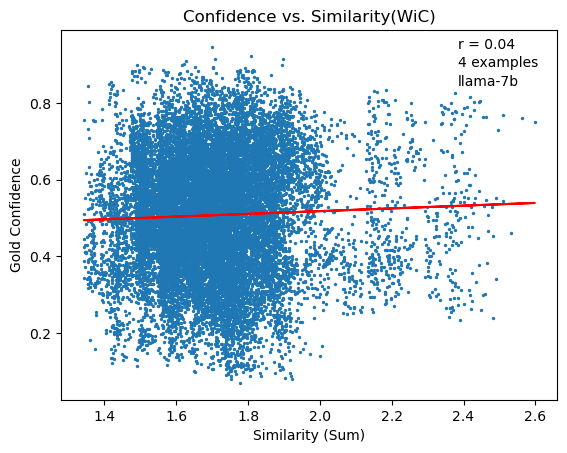

In [313]:
plot_correlation(datapoints)
plt.annotate('4 examples'.format(r), xy=(0.8, 0.9), xycoords='axes fraction')
plt.annotate(model_path, xy=(0.8, 0.85), xycoords='axes fraction')
plt.xlabel('Similarity (Sum)')
plt.ylabel('Gold Confidence')
plt.title(f'Confidence vs. Similarity({task})')
plt.show()

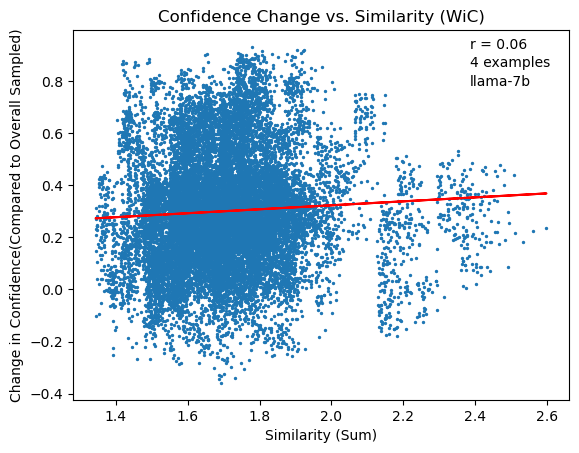

In [314]:
plt = plot_correlation(diff)
plt.annotate('4 examples'.format(r), xy=(0.8, 0.9), xycoords='axes fraction')
plt.annotate(model_path, xy=(0.8, 0.85), xycoords='axes fraction')
plt.xlabel('Similarity (Sum)')
plt.ylabel('Change in Confidence(Compared to Overall Sampled)')
plt.title(f'Confidence Change vs. Similarity ({task})')
plt.show()

In [315]:
sum([1 for x in labels[task].values() if x]) / len(labels[task].values())

0.5

In [316]:
true_probs(parsed)

{'256': 0.984375,
 '87': 0.640625,
 '581': 0.9375,
 '122': 0.171875,
 '14': 0.921875,
 '512': 1.0,
 '387': 0.40625,
 '280': 0.796875,
 '314': 0.90625,
 '4': 0.859375,
 '629': 1.0,
 '427': 1.0,
 '557': 0.546875,
 '189': 0.828125,
 '238': 0.90625,
 '335': 1.0,
 '608': 1.0,
 '348': 0.609375,
 '495': 0.015625,
 '501': 0.703125,
 '576': 0.59375,
 '598': 0.484375,
 '146': 0.859375,
 '94': 0.4375,
 '471': 0.890625,
 '592': 0.359375,
 '293': 0.5625,
 '307': 0.984375,
 '277': 0.765625,
 '174': 0.953125,
 '449': 0.828125,
 '35': 0.703125,
 '539': 0.171875,
 '434': 0.984375,
 '45': 0.84375,
 '444': 0.578125,
 '433': 0.328125,
 '549': 1.0,
 '38': 0.984375,
 '294': 0.71875,
 '399': 0.984375,
 '393': 0.328125,
 '637': 0.921875,
 '99': 0.90625,
 '506': 0.484375,
 '492': 0.953125,
 '141': 0.328125,
 '93': 1.0,
 '595': 0.890625,
 '401': 0.625,
 '498': 0.59375,
 '345': 0.03125,
 '248': 0.5,
 '605': 0.96875,
 '242': 1.0,
 '550': 0.828125,
 '56': 0.984375,
 '160': 0.375,
 '9': 0.671875,
 '380': 1.0,
 '313

In [317]:
match_probs = matching_probs(parsed, labels[task])

In [318]:
sorted(list(match_probs.items()), key=lambda x:x[1])

[('427', 0.0),
 ('608', 0.0),
 ('549', 0.0),
 ('93', 0.0),
 ('226', 0.0),
 ('633', 0.0),
 ('318', 0.0),
 ('8', 0.0),
 ('413', 0.0),
 ('400', 0.0),
 ('407', 0.0),
 ('201', 0.0),
 ('580', 0.0),
 ('168', 0.0),
 ('483', 0.0),
 ('337', 0.0),
 ('495', 0.015625),
 ('434', 0.015625),
 ('38', 0.015625),
 ('56', 0.015625),
 ('461', 0.015625),
 ('85', 0.015625),
 ('181', 0.015625),
 ('345', 0.03125),
 ('586', 0.03125),
 ('566', 0.03125),
 ('491', 0.03125),
 ('466', 0.03125),
 ('72', 0.03125),
 ('615', 0.046875),
 ('191', 0.046875),
 ('525', 0.046875),
 ('581', 0.0625),
 ('0', 0.0625),
 ('163', 0.0625),
 ('22', 0.0625),
 ('381', 0.0625),
 ('339', 0.0625),
 ('166', 0.0625),
 ('14', 0.078125),
 ('620', 0.078125),
 ('268', 0.078125),
 ('558', 0.078125),
 ('555', 0.078125),
 ('238', 0.09375),
 ('553', 0.09375),
 ('227', 0.09375),
 ('216', 0.09375),
 ('208', 0.09375),
 ('595', 0.109375),
 ('440', 0.109375),
 ('241', 0.109375),
 ('239', 0.109375),
 ('162', 0.109375),
 ('452', 0.125),
 ('361', 0.125),
 (

In [319]:
oracle(parsed, labels[task])

0.9466666666666667

In [320]:
prob_hist(matching_probs.values())

AttributeError: 'function' object has no attribute 'values'

In [ ]:
icprobs, ictotals = in_context_stats(parsed, labels[task])

In [ ]:
pair_visualization(icprobs, "Accuracy of In-context Demonstrations")

In [ ]:
pair_visualization(ictotals, "Usage of In-context Demonstrations")

In [ ]:
gen_dir = os.path.join("/nethome/dhe83/mice/experiments/", task, exp_dir, gen_dir) 

In [ ]:
get_similarity_scores(gen_dir)

In [ ]:
ic_similarities = {idxs: sum() for idxs in ic_probs.keys()}
for ic_p

In [ ]:
# Will need to correlation between prob of correct answer and similarity score